# Instance separation and tracking
### car tracking
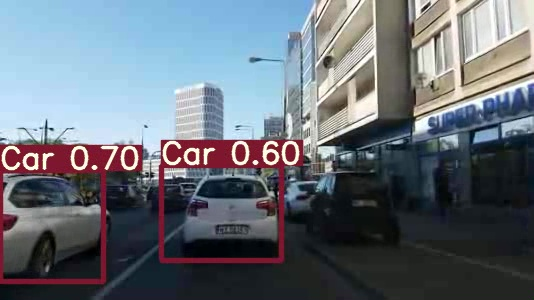








## 1. Architecture of the neural network and justification.

To start with I will  consider  the  tracking  problem  as  a  subset of    object detection problem, which is normally  called instance detection.

**First:**


---



Generally: I would spend a bit more time to research what directions/architectures are now(end of 2020) state of the art on the market  and best leveraging price/ speed/ flexibilty  and other assumed project's metrics.
 
`Given  "know how" and time(deadline 22/11/2020) which are initial limits I go directly to second point `





**Second:**


---



 I know that  CNN networks could recognize objects so I take initially one of the member of this family for further evaluation. The family is big and growing all the time. Only the Keras framework is home to a large number of its members:

 `(import keras.applications; dir(keras.applications)) 'DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', 'builtins', 'cached', 'doc', 'file', 'loader', 'name', 'package', 'path', 'spec', 'densenet', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception'` 
 
 I was using 'VGG16' so will also start with this architecture modyfying  it a bit

_Modifications:_

Constructing a new FC layer head with two branches:



*   Branch #1: A series of FC layers that end with a layer with (1) regresion four neurons, corresponding to the top-left and bottom-right (x, y)-coordinates of the predicted bounding box and (2) a sigmoid activation function, such that the output of each four neurons lies in the range "[0, 1]". This branch is responsible for  bounding box predictions.
*`bounding_box (Dense)            (None, 4)            132         dense_7[0][0] ` 

 

*   Branch #2: typical classification dependent how many classses  This branch is in charge of making class label predictions( Car. Motocycle, Truck etc,).
*   `class_label (Dense)             (None, 3)            1539        dropout_3[0][0]`  
This FC layer head (with the two branches for regresion and classification) will on top of the VGG16 body

**Third:**


---


 Evaluate results: accuracy and loss as well as overfitting problem and ajust archtecture. look for better solutions


Architecture looks like below:

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
for nr, layer in enumerate(model.layers):
    print(nr, layer.name, layer.trainable)

trainable layers are :



```
0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_1 True
20 dense_8 True
21 dense_5 True
22 dropout_2 True
23 dense_6 True
24 dense_9 True
25 dense_7 True
26 dropout_3 True
27 bounding_box True
28 class_label True
```



## 2. Way of processing with  the input material.



Video file(MPG4) is a set of frames  with own parameters:



```
import cv2

cap = cv2.VideoCapture("test.mp4")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
width, height, length, fps,  length/fps, 

(224, 224, 7598, 29, 262.0, 's')
```



Once the model will be trained on pictures from Google resized to VGG shape ie 224x224 similarly given mpg4 file's frames  will be prepared and then detection made on each one.

## 3. Method of developing and dividing the dataset into a training, test and validation set

To get annotated pictures I used google repository Open Image Dataset V4(now6) and toolkit from https://github.com/EscVM/OIDv4_ToolKit

( except installing standard libraries from requirements.txt actually server required a bit more: when I tried to copy pictures on google Drive got error “aws: not found sh: 1: aws: not need install extra library !pip install awscli

and from that library was downloaded initially 1000 pictures from 3 subclaasess Car, Truck, Motocycle.

	   ___   _____  ______            _    _    
	 .'   `.|_   _||_   _ `.         | |  | |   
	/  .-.  \ | |    | | `. \ _   __ | |__| |_  
	| |   | | | |    | |  | |[ \ [  ]|____   _| 
	\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
	 `.___.'|_____||______.'   \__/     |_____|


         _____                    _                 _             
        (____ \                  | |               | |            
         _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
        | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
        | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
        |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                      
    
[INFO] | Downloading Car.
Car INFO | Downloading train images. INFO | INFO Found 89465 online images for train.

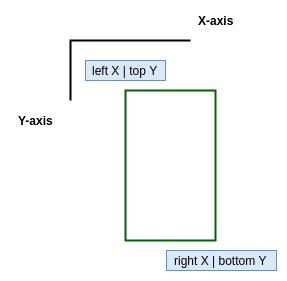
Annotations

In the original dataset the coordinates of the bounding boxes are made in the following way:

XMin, XMax, YMin, YMax: coordinates of the box XMin: 0 is the leftmost pixel, and max is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel . So, the four different values correspond to the actual number of pixels of the related image.

Each set has ~300MB from the training perspective 1000 is not big number so most likelly some data augumentation could be considered but then is problem about bounding boxes how to rotate and ajust them for transformed pictures

There was need to create/collect information about annotation from 1000 separate text files to one file  with all annotations so file will look like :


```
Filename, Starting x-coordinate, Starting y-coordinate, Ending x-coordinate,Ending y-coordinate, Class label
```



In reality




```
!head -n 5 car.csv
```


```
64763abe6fb31d41.jpg,145,46,892,484,Car
64763abe6fb31d41.jpg,582,0,1023,169,Car
82ad8ef51b6e6e37.jpg,0,0,1022,1022,Car
82ad8ef51b6e6e37.jpg,237,639,292,672,Car
f5ac8c65fdf2ea79.jpg,243,296,946,863,Car
```



Dividing on training test sets was done in a default way ie 80/20 with standard sklearn library



```
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=2020)
```



Initial configuration was prepared locally in conda environment( *requirements.txt is included*) but the training was done in Google Colab.
After training 10 epochs on Google Colab:



```
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
```





```
Epoch 10/10
160/160 [==============================] - 25s 153ms/step - loss: 0.0988 - bounding_box_loss: 0.0316 - class_label_loss: 0.0672 - bounding_box_accuracy: 0.7491 - class_label_accuracy: 0.9826 - val_loss: 0.4834 - val_bounding_box_loss: 0.0606 - val_class_label_loss: 0.4228 - val_bounding_box_accuracy: 0.6341 - val_class_label_accuracy: 0.8898
```



I looked at plots:



```
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()
```





```
plots_={'class_label_accuracy', 'bounding_box_accuracy', 'class_label_loss', 'bounding_box_loss'}
for plot in plots_:
  draw_learning_curve(H2, key= plot, ylim=(0.0, 1.))
```



and it seems like overfitting was starting in 2 or 3 epoch so I  increased Droput to 0.7 and characteritics were better

Initial characteristics:

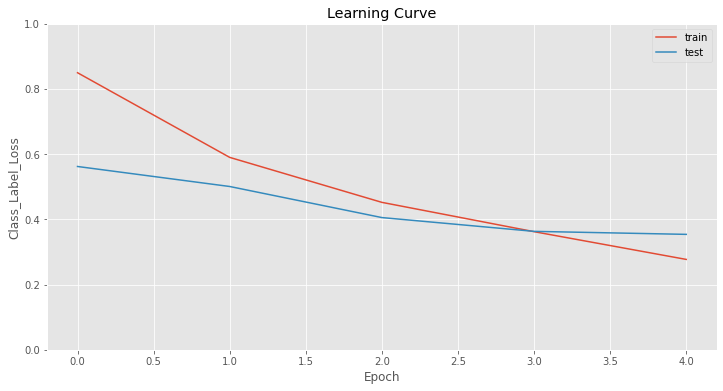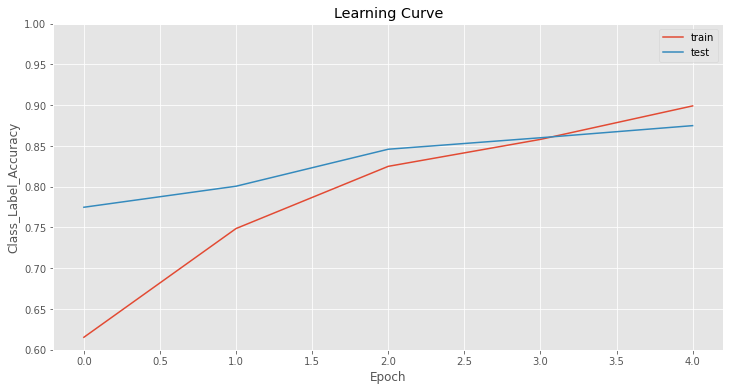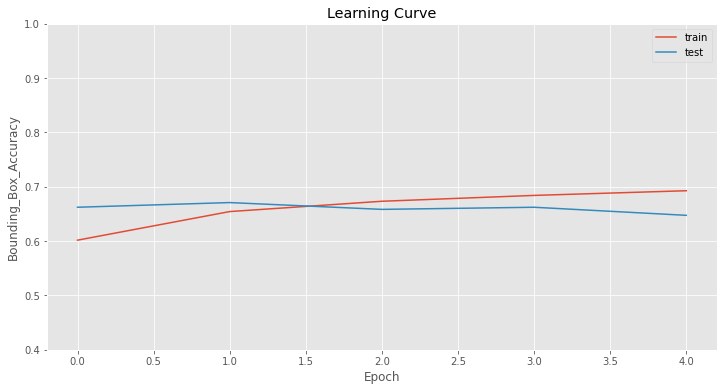

After increasing droput:

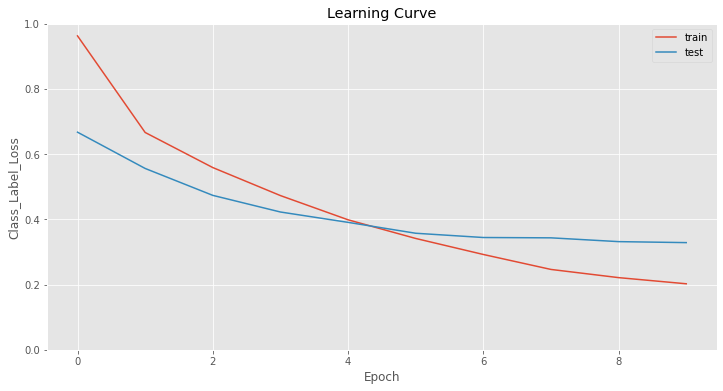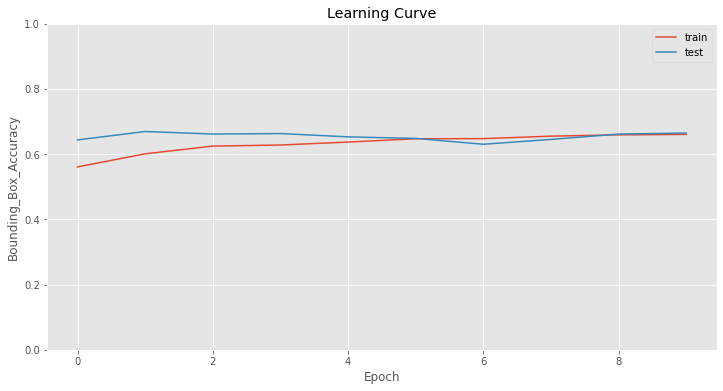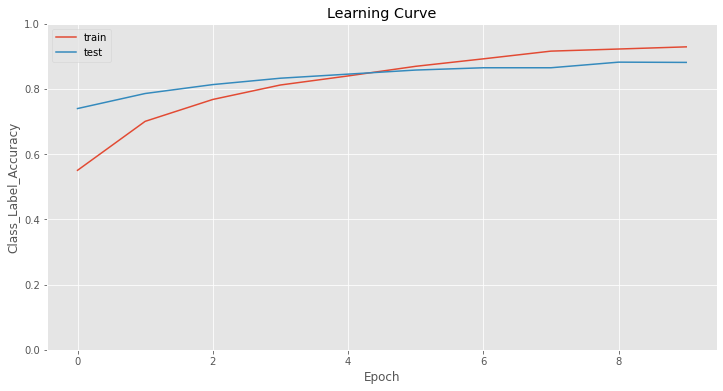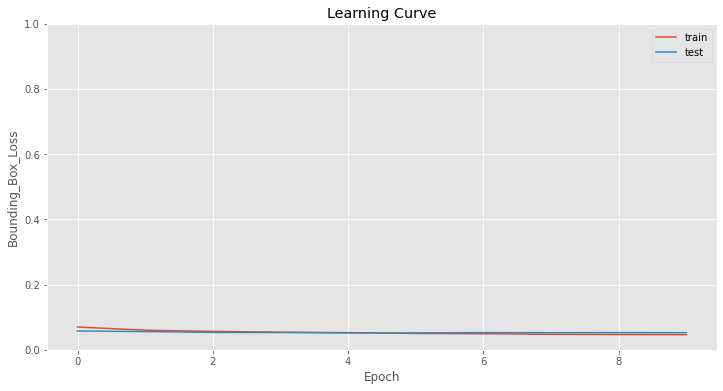

This time it looked better 


---


In the mean time.I was trying to catch up with what the other are doing to solve instance separation and segmentation. I will not write here about the Objectron  model  from Google and Detectron from Facebook surelly they great but not  in size and inference time especially if someone is using CPU on own laptop which for me was the case( I tried detectron). I also found famous YOLO family. Looked at the performance and  realised that is the direction and as time was not on my side VGG16 with two heads will be dropped( and kept as rehearsal) at that point.


## It is YOLO time

Quick glance at the  [Github](https://github.com/ultralytics/yolov5) repository, big chapter with tutorials, lot of updates and first chart was very promising

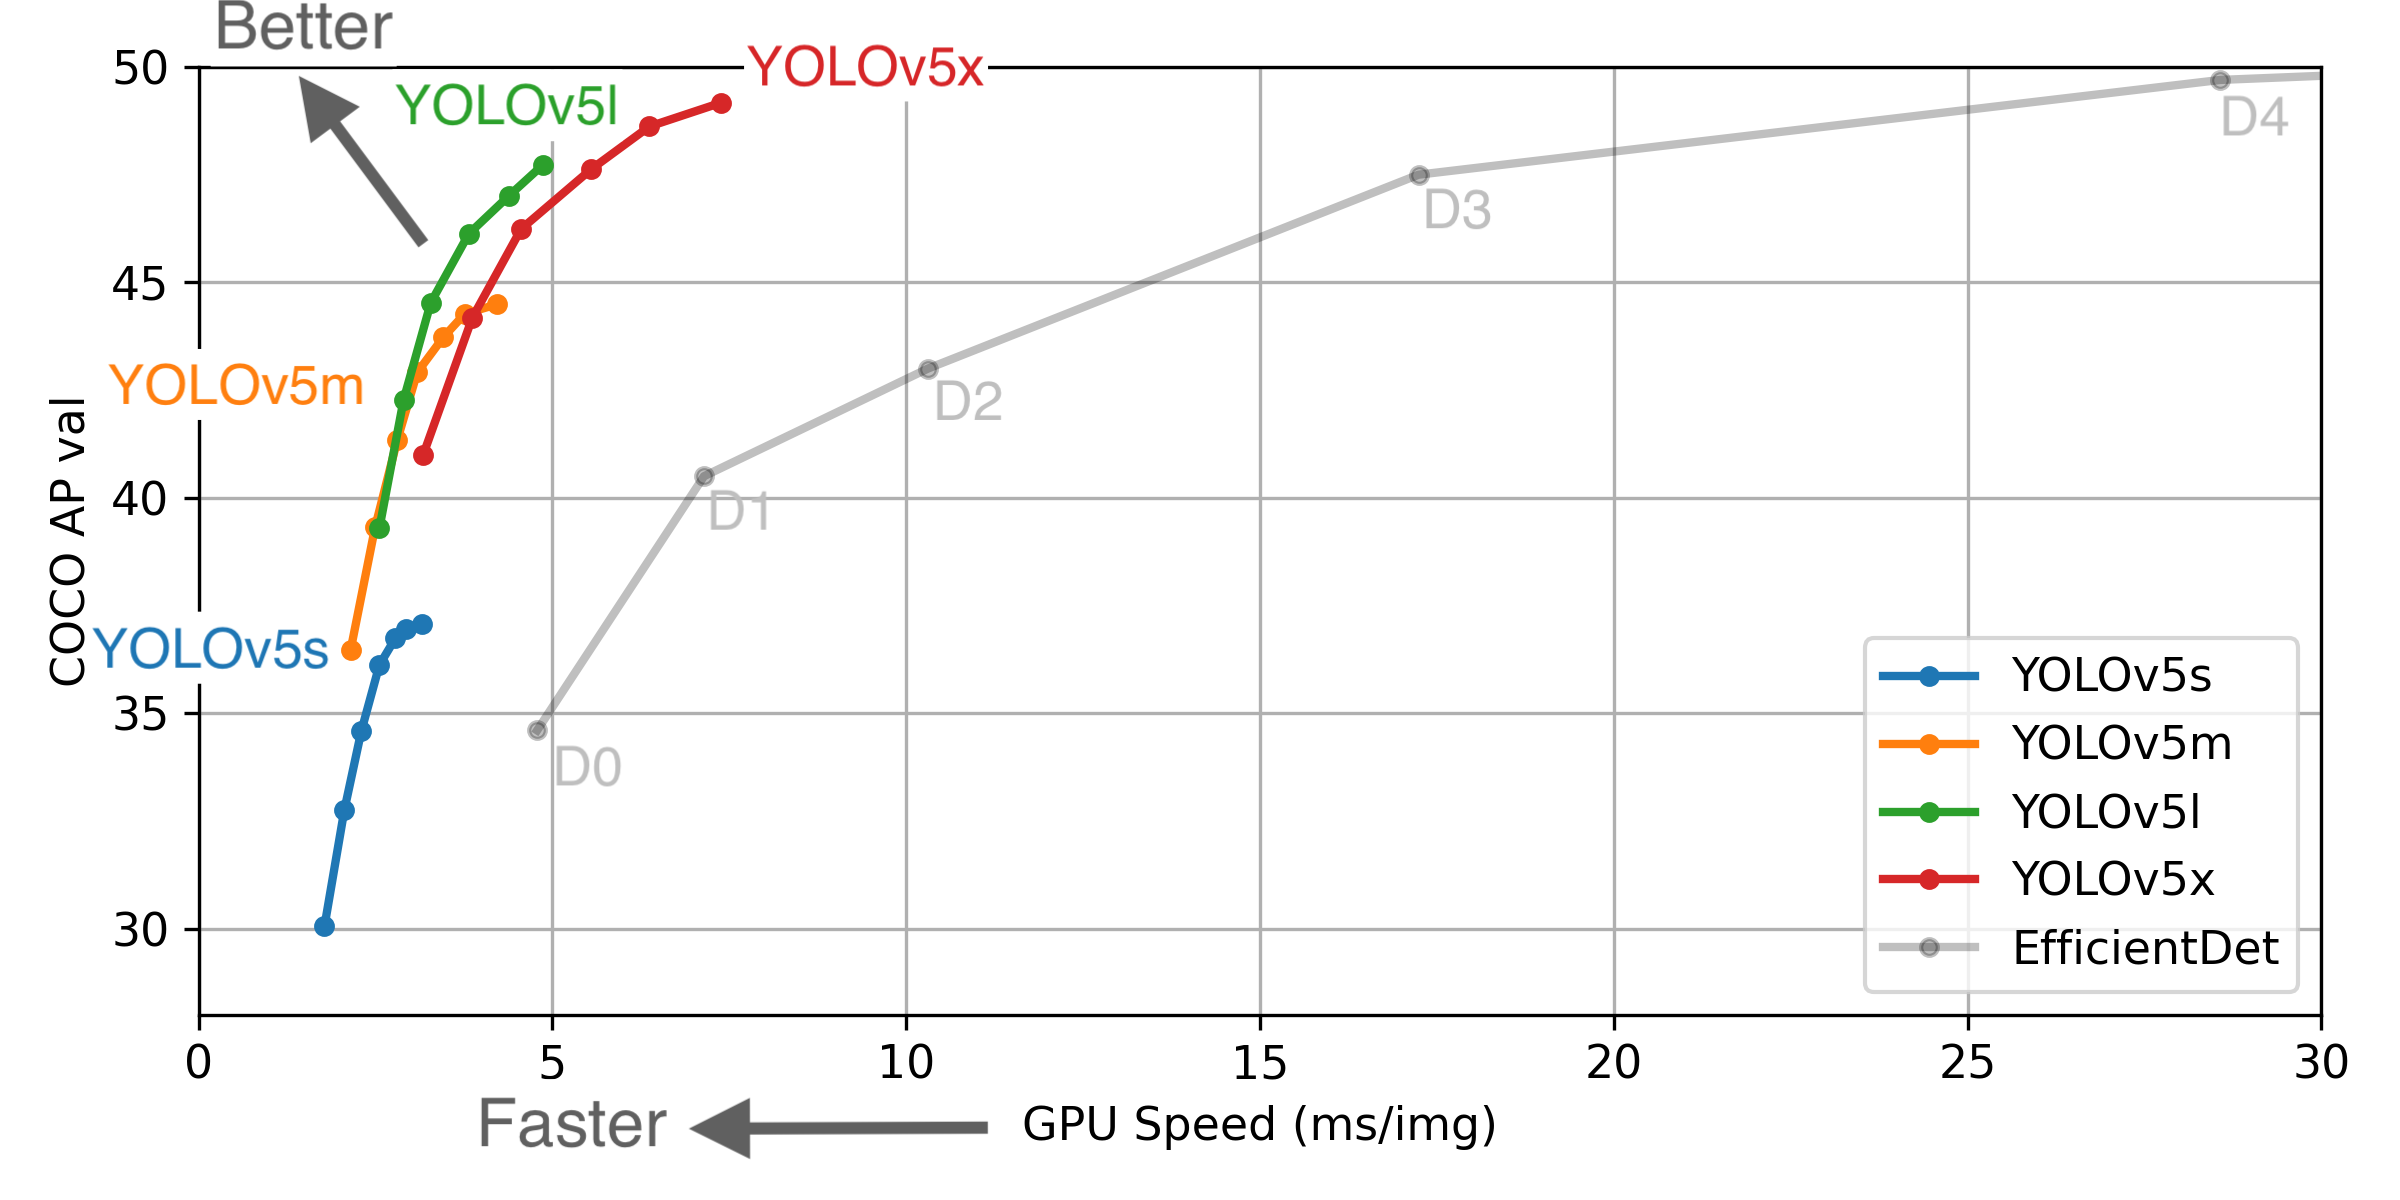

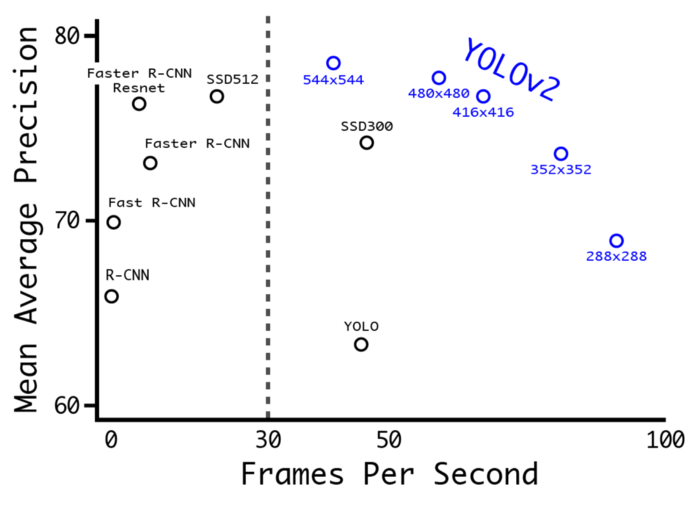

proceeding with first approach I already saw big limitation( for me) :
if I try to augument the data ie mirror cut rotate mix  etc because of absolute coordinates of bounding boxes


Other Challenges: 
[source](https://towardsdatascience.com/yolo-you-only-look-once-3dbdbb608ec4)

---



1. Variable Number of Objects

Object Detection is the problem of locating and classifying a variable number of objects in an Image. The important thing is the “variable” part. The number of objects to be detected might vary from image to image. So the main problem associated with this is that in Machine Learning models, we usually need to represent the data in fixed-sized vectors. Since the number of objects in the Image is unknown to us beforehand, we would not know the correct number of outputs and we may require some post-processing which adds up the complexity.
2. Multiple Spatial Scales and Aspect Ratios

The Objects in the Images are of multiple spatial scales and aspect ratios, there may be some objects that cover most of the image and yet there will be some we may want to find but are as small as a dozen pixels (or a very small percentage of the Image). Even the same objects can have different Scales in different images. These varying dimensions of objects pose a difficulty in tracking them down. Some algorithms use the concept of sliding windows for the purpose but it is very inefficient.
3. Modeling

Doing object detection requires solving two approaches at once-Object Detection and Object Localization. Not only we want to classify the object but we also want to locate it inside the Image. To address these, most of the researches use multi-task loss functions to penalize both misclassification errors and localization errors. Due to this duality behavior of the loss function, many times it ends up performing poorly in both.
4. Limited Data

The limited amount of annotated data currently available for object detection is another hurdle in the process. Object detection datasets typically contain annotated examples for about dozen to a hundred classes while image classification datasets can include up to 100,000 classes. Gathering the ground truth labels along with the bounding boxes for each class is still a very tedious task to solve.
5. Speed for Real-Time detection

Object detection algorithms need to be not only accurate in predicting the class of the object along with its location, but it also needs to be incredibly fast in doing all these things to coup-up with the needs of the real-time demands of video processing. Usually, a video is shot at almost 24 fps and to build an algorithm that can achieve that frame rate is quite a difficult task.


here(YOLO)  supposed to  address most of the problems considerably well:

[YOLO v3 theory explained](https://medium.com/@pylessons/yolo-v3-theory-explained-33100f6d193) 

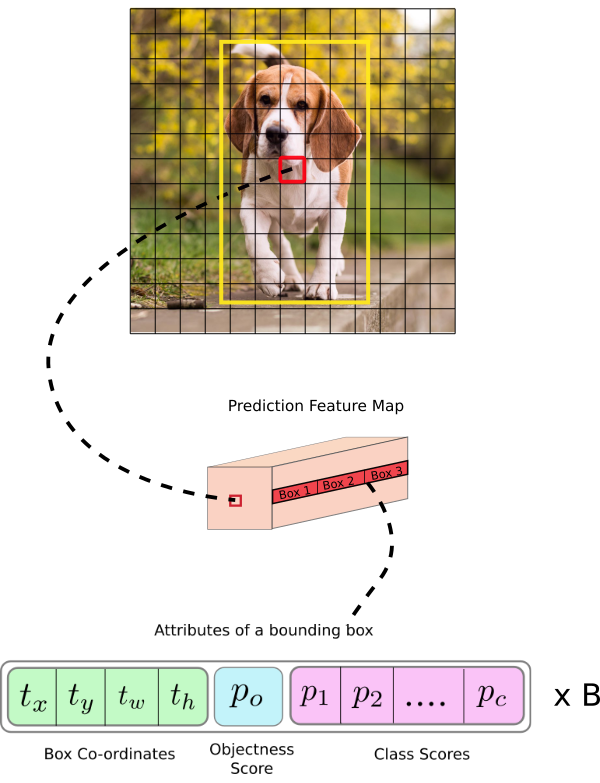

May journey  with YOLO started

Using ready to train environment  and also dataset with Vehicles  from Ultralytics
I trained ( on google colab)smallest and fastest model ie  YOLOV5s
*(once having time I do the same for the set which I prepared before for VGG16 there is need for some minor changes)*



```
Epoch   gpu_mem       box       obj       cls     total   targets  img_size
     99/99     1.86G   0.05557   0.06741   0.03047    0.1534        25       416: 100% 28/28 [00:04<00:00,  6.73it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 8/8 [00:07<00:00,  1.09it/s]
                 all         125         227       0.209       0.369       0.224      0.0955
Optimizer stripped from runs/train/yolov5s_results/weights/best.pt, 14.8MB
100 epochs completed in 0.151 hours.
```




Choosing  YOLOV5x took a bit longer  and generated much bigger pytorch weights  file ( what was mentioned at the beginning
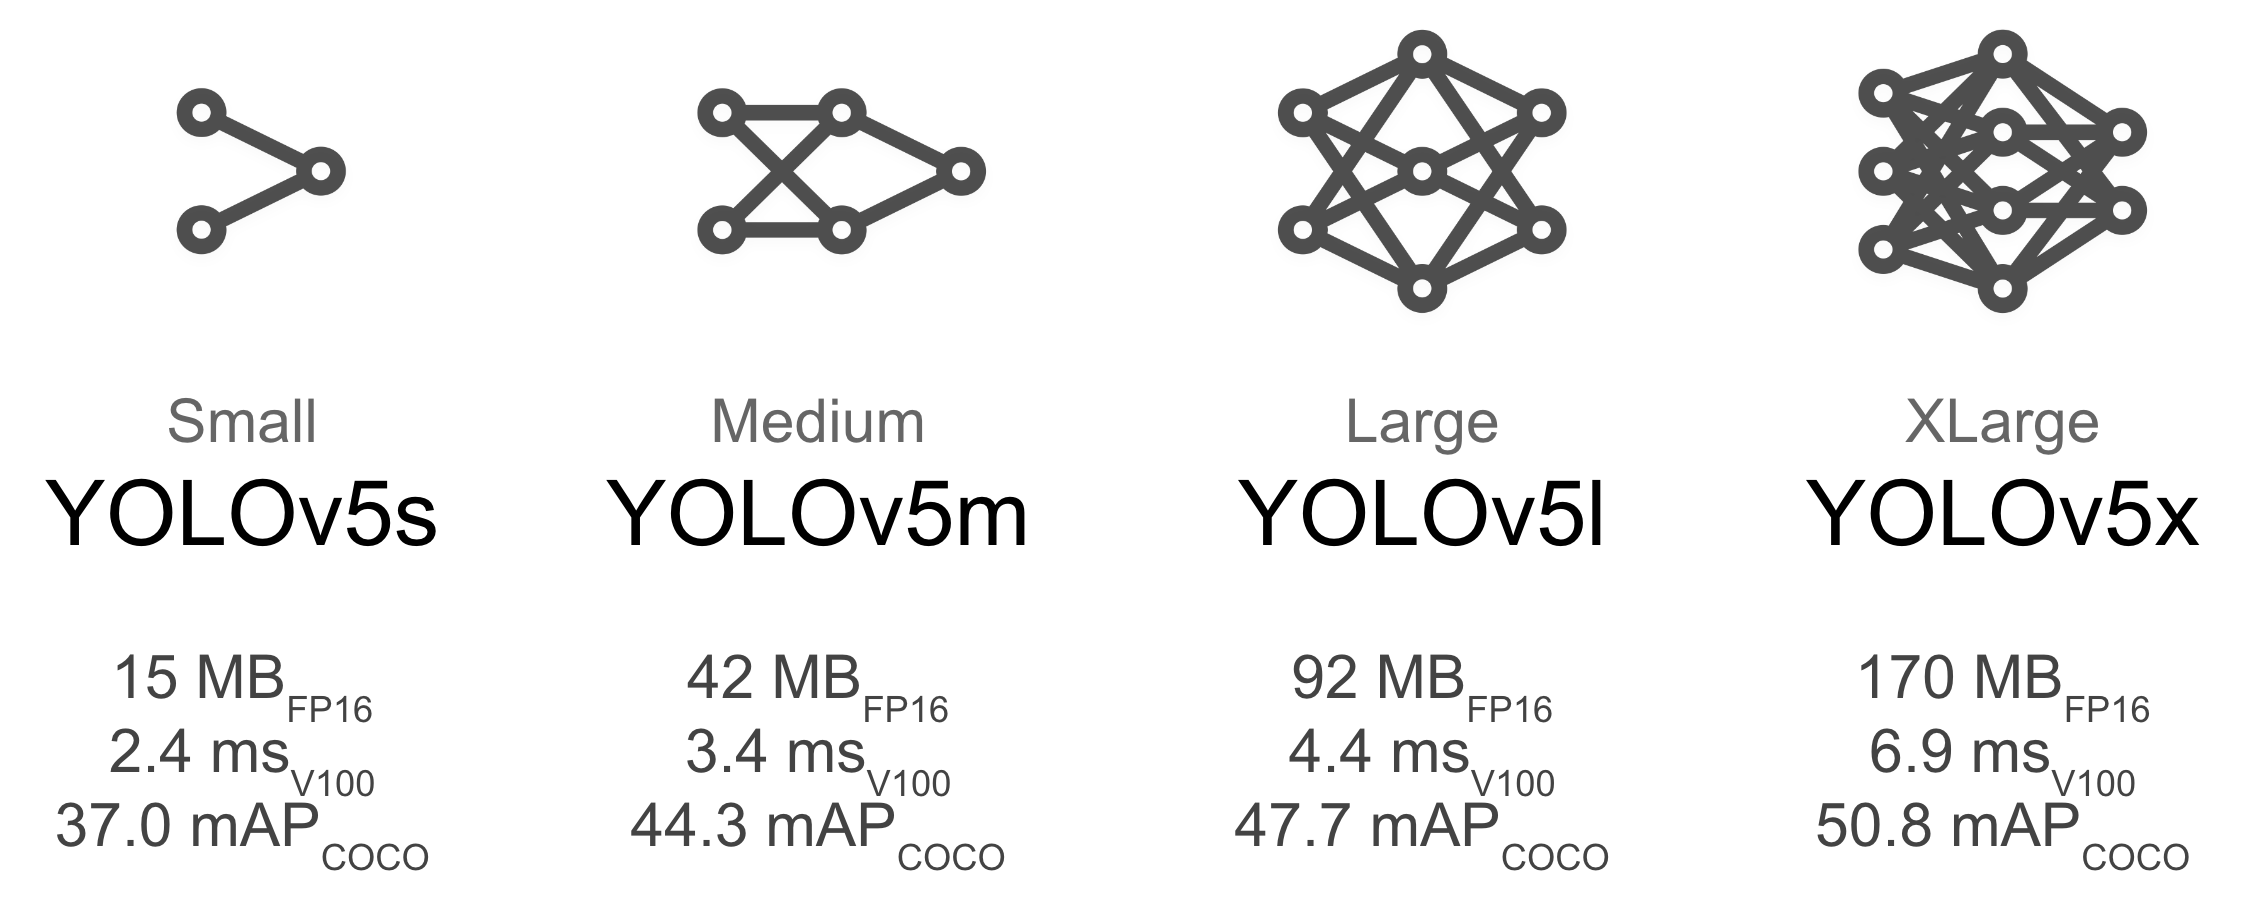




```
    Epoch   gpu_mem       box       obj       cls     total   targets  img_size
     99/99     6.83G   0.04858     0.064   0.02556    0.1381        21       416: 100% 28/28 [00:17<00:00,  1.57it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 8/8 [00:08<00:00,  1.02s/it]
                 all         125         227       0.248       0.541       0.319       0.175
Optimizer stripped from runs/train/yolov5x_results2/weights/best.pt, 177.5MB
100 epochs completed in 0.702 hours.

CPU times: user 7.06 s, sys: 1.58 s, total: 8.64 s
Wall time: 42min 30s
```



Summary of characteristcs  after training
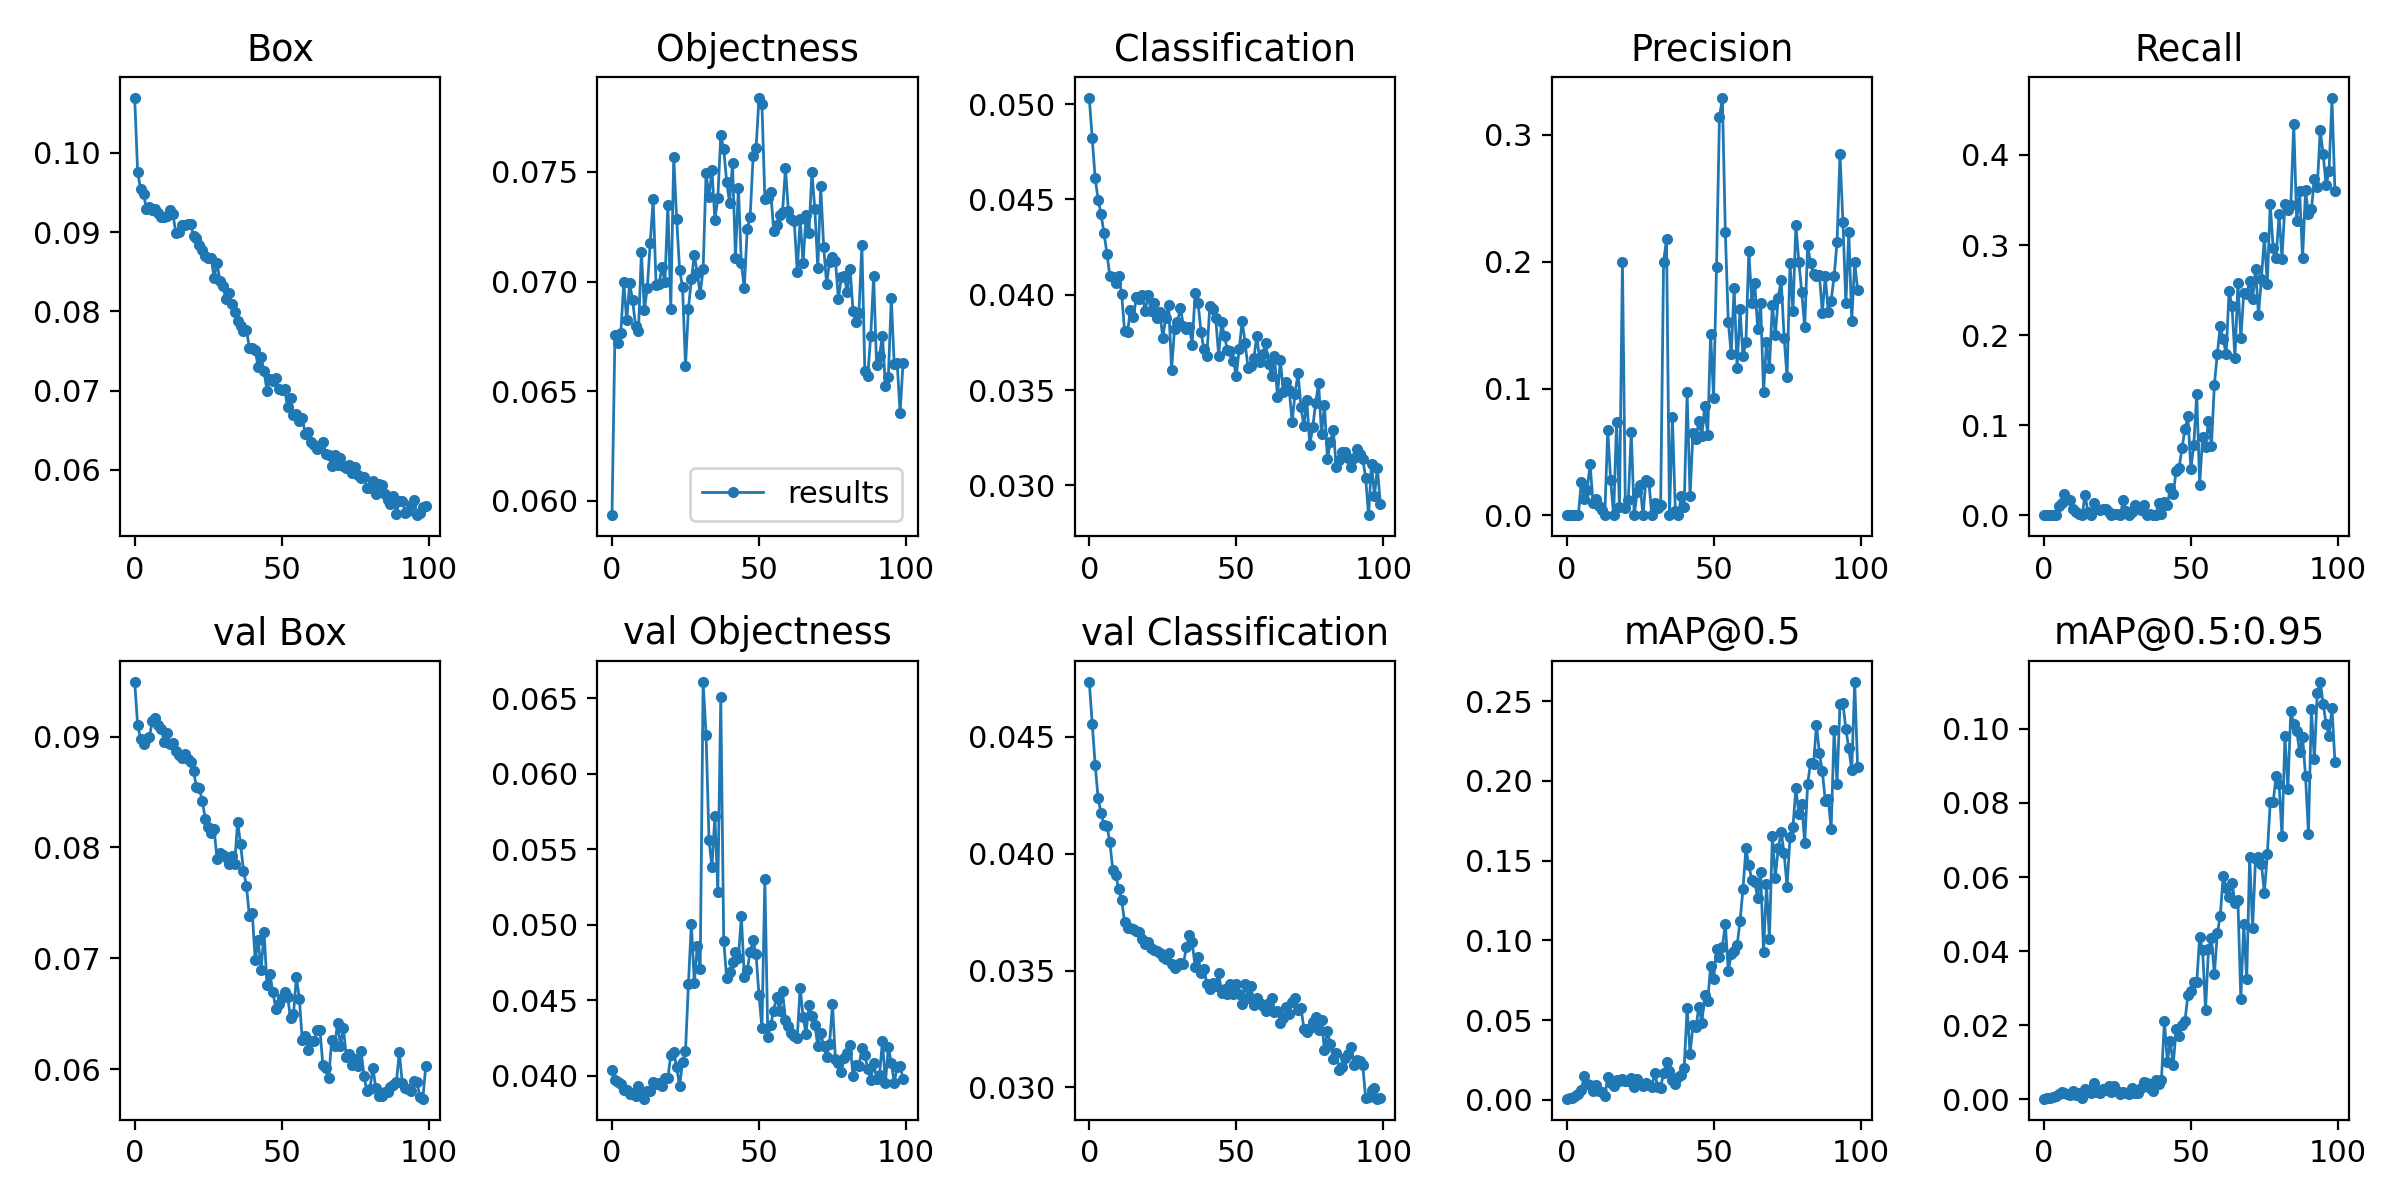

Precision has some peaks( at some points deviations  are to big so it remainds me of too small dataset from other keras excercises) trend as such is typical. 

---

I checked video file created  after prediction.
There are many cars which are not detected especially if they are close to camera, close together or very small. Confidence was set to 60 % certainly need to train with more pictures(easiest way, also make more augumentation)  especially that on V6 there are over 7000 labeled examples in train set alone



```
video 1/1 (45913/45913) /content/yolov5/0002-20170519-2.mp4: 384x640 1 Cars, Done. (0.034s)
Results saved to runs/detect/exp2
Done. (1737.279s
```



## Way of preparing and saving format of the result set.

After inference on mp4 file with conf-thres >= 0.6

there were
10960 txt files created with information about recognized class name,
each file name contains frame number/frame_stamp at the end



```
dir_listing_Car = list_per_time(search_dir_Car)
dir_listing_Car[-10:]
 '/content/yolov5/runs/detect/exp2/labels/0002-20170519-2_45910.txt',
 '/content/yolov5/runs/detect/exp2/labels/0002-20170519-2_45911.txt',
 '/content/yolov5/runs/detect/exp2/labels/0002-20170519-2_45912.txt',
 '/content/yolov5/runs/detect/exp2/labels/0002-20170519-2_45913.txt']
```





content of the file is a standard YOLO format ie


```
class_idx x_center y_center width height
```





```
!head -n 4  /content/yolov5/runs/detect/exp3/labels/0002-20170519-2_10021.txt
2 0.235955 0.63 0.0561798 0.08 0.606934
2 0.156367 0.63 0.0617978 0.0733333 0.62207
```



Of course that could be easilly collected in one file where columns are:


```
'frame_nr','filename', 'class', 'left_x', 'top_y', 'width', 'height'
```


```
!head -n 5 /content/yolov5/cars.csv
frame_nr,filename,class,left_x,top_y,width,height
22,0002-20170519-2_22.mp4,2,0.802434,0.698333,0.338951,0.37
23,0002-20170519-2_23.mp4,2,0.80618,0.698333,0.342697,0.37
24,0002-20170519-2_24.mp4,2,0.807116,0.698333,0.344569,0.37
25,0002-20170519-2_25.mp4,2,0.809925,0.701667,0.338951,0.37
```




# Short summary

Taking in consideration deadline I am barelly scratched the surface and more experiments are required.


Even after very limited usage of YOLO it looks like object detector :


*   does not always handle small objects well

*    does not handle objects grouped close together




---

Explanation could be:
The YOLO object detector divides an input image into an SxS grid where each cell in the grid predicts only a single object. If there exist multiple, small objects in a single cell then YOLO will be unable to detect them, ultimately leading to missed object detections. Cars are relativelly big so it should be sufficient



    

  


I could only repeat again: To build leveraged opinion about usage of particul architecture  for particular purpose there is need for time and many well documented structured experiments.

### Other comments

What I will be looking for the future:
to make preprocessing for experiments( video based input) quickly 
there is need to create pipe where movie from internet source will be:


1.   downloaded
2.   trimed to specified time
3.   resized to min sufficiend shape
4.   everything done in colab and with colab constrains





_Created by len.sla_ 20/11/2020